<a href="https://colab.research.google.com/github/CesarRoldan99/CEE88_Cesar/blob/main/LAB8/Transfer_Learning_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "cesarroldan" # username from the json file
os.environ['KAGGLE_KEY'] = "a1b8be2babe27c76bf1a54149bd8668a" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle (https://www.kaggle.com/c/dogs-vs-cats/data)

 97% 529M/543M [00:08<00:00, 50.0MB/s]
100% 543M/543M [00:08<00:00, 63.9MB/s]
100% 270M/271M [00:05<00:00, 53.0MB/s]
100% 271M/271M [00:05<00:00, 49.9MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 72.6MB/s]


In [3]:
# Unzip training data
from zipfile import ZipFile
file_name = "/content/train.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [4]:
# Get all the paths
data_dir_list = os.listdir('/content/train')
#print(data_dir_list)
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print(file_count)

25000


In [9]:
# Make new base directory
original_dataset_dir = '/content/train'
base_dir = '/content/cats_and_dogs_small'
os.mkdir(base_dir)

In [10]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [13]:
import shutil
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [14]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [15]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'dog': return 1
    elif word_label == 'cat': return 0

In [17]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [18]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)

In [28]:
print(len(train_X))
print(len(val_X))
print(len(test_X))

2000
1000
1000


In [110]:
## VGG 16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [113]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [117]:
last_layer = model.get_layer('fc2').output
out = Dense(4, activation='sigmoid', name='output')(last_layer)  ## 4 classes
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False

model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [37]:
history = model.fit(train_X, train_y,
                               batch_size=10,
                               epochs=10, 
                               validation_data=(val_X, val_y),
                               callbacks=my_callbacks)

Epoch 1/10
200/200 [==============================] - 70s 187ms/step - loss: 0.5786 - acc: 0.6708 - val_loss: 0.3151 - val_acc: 0.8700
Epoch 2/10
200/200 [==============================] - 37s 185ms/step - loss: 0.3340 - acc: 0.8615 - val_loss: 0.2704 - val_acc: 0.8850
Epoch 3/10
200/200 [==============================] - 37s 186ms/step - loss: 0.2742 - acc: 0.8861 - val_loss: 0.2439 - val_acc: 0.8960
Epoch 4/10
200/200 [==============================] - 37s 185ms/step - loss: 0.2441 - acc: 0.9093 - val_loss: 0.4870 - val_acc: 0.7660
Epoch 5/10
200/200 [==============================] - 37s 186ms/step - loss: 0.3017 - acc: 0.8597 - val_loss: 0.2796 - val_acc: 0.8750
Epoch 6/10
200/200 [==============================] - 37s 185ms/step - loss: 0.2233 - acc: 0.8998 - val_loss: 0.2222 - val_acc: 0.8970
Epoch 7/10
200/200 [==============================] - 37s 186ms/step - loss: 0.2084 - acc: 0.9199 - val_loss: 0.2615 - val_acc: 0.8780
Epoch 8/10
200/200 [==============================] - 3

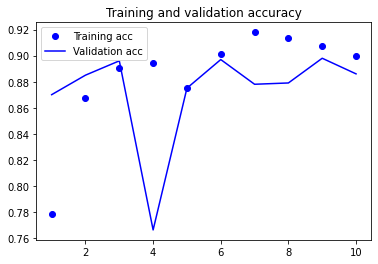

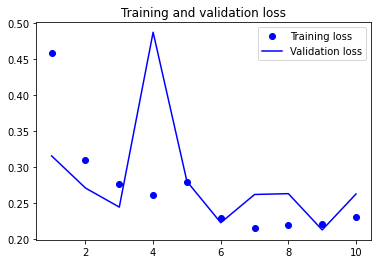

In [38]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.8999999761581421
Val Accuracy:	 0.8859999775886536
Test Accuracy:	 0.878
Precision:	 0.9543269230769231
Recall:		 0.794
F1 Score:	 0.8668122270742359
AUC:		 0.878


**My model using data.zip**

In [42]:
# Unzip training data
from zipfile import ZipFile
file_name = "/content/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [53]:
import os
# Get all the paths
data_dir_list = os.listdir('/content/data')
print("Number of Folders:",len(data_dir_list))
for folder in data_dir_list:
    print(folder)
    print("# of files:",len(os.listdir('/content/data/' + folder)))


Number of Folders: 4
Humans
# of files: 202
cats
# of files: 202
dogs
# of files: 202
horses
# of files: 202


In [54]:
# Make new base directory
original_dataset_dir = '/content/data'
base_dir = '/content/LAB8'
os.mkdir(base_dir)

In [55]:
# Directories
# For training.
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

# For validation.
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# For testing.
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [304]:
# Splitting in training, validation, test. 
import shutil

# For cats.
fnames = ['cat.{}.jpg'.format(i+1) for i in range(102)]
# Training
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/cats", fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i+1) for i in range(102, 152)]
# Validation
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/cats" , fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i+1) for i in range(152, 202)]
# Testing
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/cats", fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)
#---------------------------------------------------------------


#  For dogs.   
fnames = ['dog.{}.jpg'.format(i+1) for i in range(102)]
# Training
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/dogs", fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i+1) for i in range(102, 152)]
# Validation
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/dogs", fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i+1) for i in range(152, 202)]
# Testing
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/dogs", fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)
#---------------------------------------------------------------


#  For Horses.   
fnames = ['horse-{}.jpg'.format(i+1) for i in range(102)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/horses", fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['horse-{}.jpg'.format(i+1) for i in range(102, 152)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/horses", fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['horse-{}.jpg'.format(i+1) for i in range(152, 202)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/horses", fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)
#---------------------------------------------------------------


#  For Humans.   
fnames = ['rider-{}.jpg'.format(i+1) for i in range(102)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/Humans", fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['rider-{}.jpg'.format(i+1) for i in range(102, 152)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/Humans", fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['rider-{}.jpg'.format(i+1) for i in range(152, 202)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + "/Humans", fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [305]:
# Labeling images

import cv2
import numpy as np
from random import shuffle

def label_images(img):
    point_label = img.split('.')[0]
    dash_label = img.split('-')[0]
    if point_label == 'cat': return 0
    elif point_label == 'dog': return 1
    elif dash_label == 'horse': return 2
    elif dash_label == 'rider': return 3


In [306]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_images(img)
        #print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (299, 299))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [307]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)

In [308]:
print(len(train_X)) # Each class 102 images
print(len(train_y)) # Each class 102 labels
print(len(val_X))   # Each class 50 images
print(len(val_y))   # Each class 50 lables
print(len(test_X))  # Each class 50 images
print(len(test_y))  # Each class 50 lables

408
408
204
204
204
204


In [309]:
## VGG 16
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras import Sequential

img_input = Input(shape=(299, 299, 3))

In [ ]:
model = Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
model.summary()

In [311]:
last_layer = model.get_layer('avg_pool').output
out = Dense(4, activation='softmax', name='Dout')(last_layer)
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False


model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [312]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [313]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [314]:
history = model.fit(train_X, train_y,
                    batch_size=10,
                    epochs=10, 
                    validation_data=(val_X, val_y),
                    callbacks=my_callbacks)

Epoch 1/10
41/41 [==============================] - 14s 284ms/step - loss: 0.9836 - acc: 0.6316 - val_loss: 0.2671 - val_acc: 0.9853
Epoch 2/10
41/41 [==============================] - 11s 264ms/step - loss: 0.2791 - acc: 0.9451 - val_loss: 0.1277 - val_acc: 0.9951
Epoch 3/10
41/41 [==============================] - 11s 265ms/step - loss: 0.1540 - acc: 0.9728 - val_loss: 0.0976 - val_acc: 1.0000
Epoch 4/10
41/41 [==============================] - 11s 266ms/step - loss: 0.1237 - acc: 0.9667 - val_loss: 0.0680 - val_acc: 1.0000
Epoch 5/10
41/41 [==============================] - 11s 267ms/step - loss: 0.1018 - acc: 0.9710 - val_loss: 0.0556 - val_acc: 1.0000
Epoch 6/10
41/41 [==============================] - 11s 267ms/step - loss: 0.0634 - acc: 0.9897 - val_loss: 0.0576 - val_acc: 1.0000
Epoch 7/10
41/41 [==============================] - 11s 267ms/step - loss: 0.0492 - acc: 0.9947 - val_loss: 0.0413 - val_acc: 1.0000
Epoch 8/10
41/41 [==============================] - 11s 266ms/step - 

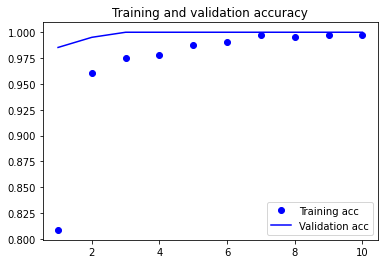

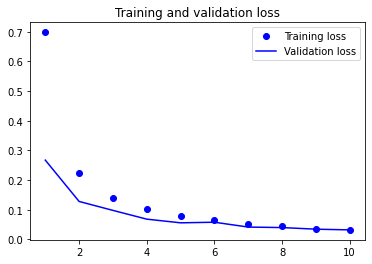

In [315]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [317]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
y = np.argmax(predictions,axis=1)
test_acc = accuracy_score(test_y, y)
print(test_acc)

0.9852941176470589


In [318]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, y, average='weighted')

auc = roc_auc_score(test_y, predictions, multi_class="ovr")

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9975489974021912
Val Accuracy:	 1.0
Test Accuracy:	 0.9852941176470589
Precision:	 0.9853883861236803
Recall:		 0.9852941176470589
F1 Score:	 0.9852936464406006
AUC:		 0.9998718441625016
